# Evaluation of the Classifier

This is the evaluation script of the classifier that outputs a vector of size 5.

### library and package importation

In [1]:
import random
import os
import shutil
import glob
import gc
import sys
import h5py
import time
import datetime
import pickle
import librosa
import warnings
import matplotlib.pyplot as plt

from graphs import draw
import graphs

import numpy as np
from numpy import array
import pandas as pd
from pandas.plotting import parallel_coordinates
from pydub import AudioSegment

#imported for testing
import wave
import contextlib

# for outputing file
from scipy.cluster.vq import vq, kmeans, whiten
import scipy.stats.stats as st

from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from sklearn.datasets.samples_generator import make_blobs
from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import normalize
from sklearn.metrics import auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import mixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.utils import class_weight

import keras

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.constraints import maxnorm
from keras.layers import Convolution1D, Dense, MaxPooling1D, Flatten, Add, Dropout, Input, Activation
from keras.layers import TimeDistributed, Bidirectional, LSTM, LeakyReLU
from keras.models import Sequential
from keras.models import load_model
from keras import optimizers, regularizers
from keras.utils import np_utils, to_categorical

from IPython.display import clear_output

# confirm TensorFlow sees the GPU
from tensorflow.python.client import device_lib
# assert 'GPU' in str(device_lib.list_local_devices())

# confirm Keras sees the GPU
from keras import backend
# print(len(backend.tensorflow_backend._get_available_gpus()) > 0)

sample_rate=44100
hop_length = 441  # frame size= 2*hop
segment_length=int(sample_rate*0.2)  #0.2
segment_pad=int(sample_rate*0.02)     #0.02
overlappiong=int(sample_rate*0.1)   #0.1

NumofFeaturetoUse = 272 # this will re-assigned for different classifiers
frame_number = 48

sys.path.insert(1, '..//components//')
import load_feat_directories

# input new indices file here
# indices_filename = 'D://indices_filename.npy'
# indices=np.load(indices_filename)

Using TensorFlow backend.


In [2]:
def avail_modules(directory, prefix):
    module_names = []
    for item in os.listdir(directory):
        if prefix in item:
            module_names.append(directory + item)
            i = module_names.index(directory + item)
            print(str(i) + 'th module')
            print(directory + item)
    return module_names

In [3]:
def comprise_vector(path, dist, reverb, noise):
    vec_to_return = []
    for fname in os.listdir(path):
        components = fname.split('_')
        '''
        if dist == 0 and 'deamp' in components: continue
        if reverb == 0 and 'WetDry' in components: continue
        if noise == 0 and 'noise' in components: continue
        '''
        current_vec = np.load(path + fname)
        vec_to_return.append(current_vec)
        
    vec_to_return = np.array(vec_to_return)
    return vec_to_return

In [4]:
def comprise_label(feature_vector, label):
    label_vec_to_ret = []
    length = len(list(feature_vector))
    for index in range(0, length):
        current_label = [label]
        label_vec_to_ret.append(current_label)
    label_vec_to_ret = np.array(label_vec_to_ret)

    return label_vec_to_ret

def float_compatible(input_np):

    x = np.where(input_np >= np.finfo(np.float32).max)
    for index in range(0, len(x[0])):
        x_position = x[0][index]
        y_position = x[1][index]
        input_np[x_position, y_position] = 0.0
    input_np = np.nan_to_num(input_np)

    return input_np

def update_progress(progress):
    bar_length = 100
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))
    clear_output(wait = True)
    
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [5]:
# allnoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
# homenoised_npy[0, 1, 2, 3, 4] ==> H, A, N, S, O
all_noised_npy = load_feat_directories.allnoised_npy
all_noised_npy_test = load_feat_directories.allnoised_npy_test
home_noised_npy = load_feat_directories.homenoised_npy
home_noised_npy_test = load_feat_directories.homenoised_npy_test

for index in range(0, 5):
    if not os.path.exists(all_noised_npy_test[index]):
        print(all_noised_npy_test[index] + ' does not exist. Breaking the loop... ')
    if not os.path.exists(home_noised_npy[index]):
        print(home_noised_npy_test[index] + 'does not exist. Breaking the loop... ')

In [6]:
emotions = [0, 1, 2, 3, 4]
home_or_all = 'home'
dist = 0
reverb = 0
noise = 0

for index in emotions:
    if home_or_all == 'home':
        path = home_noised_npy_test[index]
    else:
        path = all_noised_npy_test[index]
        
    if index == 0:
        val_h_feat = comprise_vector(path, dist, reverb, noise)
        val_h_label = comprise_label(val_h_feat, index)
    elif index == 1:
        val_a_feat = comprise_vector(path, dist, reverb, noise)
        val_a_label = comprise_label(val_a_feat, index)
    elif index == 2:
        val_n_feat = comprise_vector(path, dist, reverb, noise)
        val_n_label = comprise_label(val_n_feat, index)
    elif index == 3:
        val_s_feat = comprise_vector(path, dist, reverb, noise)
        val_s_label = comprise_label(val_s_feat, index)
    else:
        val_o_feat = comprise_vector(path, dist, reverb, noise)
        val_o_label = comprise_label(val_o_feat, index)     


In [7]:
def max_index(a): 
  
    # inbuilt function to find the position of minimum  
    minpos = a.index(min(a)) 
      
    # inbuilt function to find the position of maximum  
    maxpos = a.index(max(a))  
      
    return maxpos

# Evaluation in different scenarios

In [8]:
def eval_all(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            
            one_sample = np.load(emotionFolder + emotionfile)
            one_sample = np.array([one_sample])
            
            zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
            
            zero_scores.append(zero_score)
            one_scores.append(one_score)
            two_scores.append(two_score)
            three_scores.append(three_score)
            four_scores.append(four_score)
            
            result_list = [zero_score, one_score, two_score, three_score, four_score]

            if val == max_index(result_list): correct += 1
            else: incorrect += 1

            total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [9]:
def eval_original(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise 
            
            if original:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
    
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [10]:
def eval_deamplified_noised(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_n:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                components = emotionfile.split('_')
                deamplified_amount_position = components.index('deamp') + 1
                deamplified = float(components[deamplified_amount_position])
                deamplified_dbs.append(deamplified)
                
                zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
                
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [11]:
def eval_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if r:
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                components = emotionfile.split('_')
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total) )
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors, \
             'error_rate': incorrect/total, 'accuracy': correct/total, 'total_files': total}
    return mydict

In [12]:
def eval_deamplified_noised_reverbed(emotionFolders):
    total = 0
    
    zero_scores = []
    one_scores = []
    two_scores = []
    three_scores = []
    four_scores = []
    
    wetdrys = []
    diffusions = []
    decayfactors = []
    deamplified_dbs = []
    
    correct = 0
    incorrect = 0
    
    for emotionFolder in emotionFolders:
        if 'Happy' in emotionFolder: val = 0
        elif 'Angry' in emotionFolder: val = 1
        elif 'Neutral' in emotionFolder: val = 2
        elif 'Sad' in emotionFolder: val = 3
        else: val = 4

        for emotionfile in os.listdir(emotionFolder):
            dist = 'deamp_' in emotionfile
            reverb = 'WetDry_' in emotionfile and 'Diffusion_' in emotionfile and 'DecayFactor_' in emotionfile
            noise = 'noise_' in emotionfile
        
            r_n = not dist and reverb and noise 
            r = not dist and reverb and not noise
            n = not dist and not reverb and noise
            original = not dist and not reverb and not noise
            d_r_n = dist and reverb and noise
            d_r = dist and reverb and not noise
            d_n = dist and not reverb and noise
            d = dist and not reverb and not noise # does not exist
            
            if d_r_n:
                print(emotionfile)
                one_sample = np.load(emotionFolder + emotionfile)
                one_sample = np.array([one_sample])
                
                zero_score, one_score, two_score, three_score, four_score = model.predict(one_sample)[0]
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                two_scores.append(two_score)
                three_scores.append(three_score)
                four_scores.append(four_score)

                result_list = [zero_score, one_score, two_score, three_score, four_score]
                
                components = emotionfile.split('_')
                
                deamplified_position = components.index('deamp') + 1
                deamplified_dbs.append(float(components[deamplified_position]))
                
                wetdry_position = components.index('WetDry') + 1
                wetdrys.append(float(components[wetdry_position]))
                
                decayfactor_position = components.index('DecayFactor') + 1
                decayfactors.append(float(components[decayfactor_position]))
                
                diffusion_position = components.index('Diffusion') + 1
                diffusions.append(float(components[diffusion_position].split('.')[0]))
                
                zero_scores.append(zero_score)
                one_scores.append(one_score)
                
                if val == max_index(result_list): correct += 1
                else: incorrect += 1
                
                total += 1
    print('correct = ' + str(correct))
    print('incorrect = ' + str(incorrect))
    print('error rate = ' + str(incorrect/total) )
    print('accuracy = ' + str(correct/total))
    print('total files = ' + str(total))
                       
    mydict = {'one_scores': one_scores, 'zero_scores': zero_scores, \
              'two_scores': two_scores, 'three_scores': three_scores, \
              'four_scores': four_scores, \
             'wetdrys': wetdrys, 'diffusions': diffusions, 'decayfactors': decayfactors,
             'deamplified_dbs': deamplified_dbs, 'error_rate': incorrect/total, 'accuracy': correct/total, \
             'total_files': total}
    return mydict

In [13]:
def predict_cnn(model):
    y_pred = []
    y_true = []

    for item in list(Label_val):
            if item[0] > item[1]:
                y_true.append(0)
            elif item[0] < item[1]:
                y_true.append(1)
            else:
                y_true.append(0)

    for item in list(model.predict(featureSet_val)):
            if item[0] > item[1]:
                y_pred.append(0)
            elif item[0] < item[1]:
                y_pred.append(1)
            else:
                y_pred.append(0)

    print('Accuracy: ' + str(accuracy_score(y_true, y_pred)))
    print('Precision: ' + str(precision_score(y_true, y_pred)))
    print('Recall: ' + str(recall_score(y_true, y_pred)))
    print('f1 score: ' + str(f1_score(y_true, y_pred)))

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

In [14]:
# Load testing npy files
featureSet_val = float_compatible(np.vstack((val_h_feat, val_a_feat, val_n_feat, val_s_feat)))
Label_val = np.vstack((val_h_label, val_a_label, val_n_label, val_s_label))
Label_val[Label_val == 0] = 0
Label_val[Label_val == 1] = 1
Label_val[Label_val == 2] = 2
Label_val[Label_val == 3] = 3
Label_val[Label_val == 4] = 4
Label_val = to_categorical(Label_val)
print('evaluation data: ' + str(featureSet_val.shape))
print('evaluation label: ' + str(Label_val.shape))

evaluation data: (7551, 48, 272)
evaluation label: (7551, 4)


In [15]:
directory = '..//..//modules//'
module_prefix = 'All_'
modules = avail_modules(directory, module_prefix)

0th module
..//..//modules//Checkpoint_home_All_neurons_home_1024_filters_2048_dropout_0.2_epoch_1000_dense_6.hdf5
1th module
..//..//modules//Checkpoint_home_All_neurons_home_2048_filters_1024_dropout_0.2_epoch_1000_dense_4.hdf5


In [16]:
title = modules[0]
model = keras.models.load_model(title)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [17]:
# model.summary()

## Specify the directories that contain the files of emotion

In [18]:
emotionFolders = [home_noised_npy_test[0], home_noised_npy_test[1], \
                  home_noised_npy_test[2], home_noised_npy_test[3], home_noised_npy_test[4]]

## Only evaluate unmodified wav files

### evaluate the set of Happy validation

In [19]:
dictionary_original_h = eval_original([emotionFolders[0]])
zero_scores_original_h = dictionary_original_h.get('zero_scores')

correct = 315
incorrect = 25
error rate = 0.07352941176470588
accuracy = 0.9264705882352942
total files = 340


### evaluate the set of Angry validation

In [20]:
dictionary_original_a = eval_original([emotionFolders[1]])
one_scores_original_a = dictionary_original_a.get('one_scores')

correct = 301
incorrect = 25
error rate = 0.07668711656441718
accuracy = 0.9233128834355828
total files = 326


### evaluate the set of Neutral validation

In [21]:
dictionary_original_n = eval_original([emotionFolders[2]])
two_scores_original_n = dictionary_original_n.get('two_scores')

correct = 287
incorrect = 12
error rate = 0.04013377926421405
accuracy = 0.959866220735786
total files = 299


### evaluate the set of Sad validation

In [22]:
dictionary_original_s = eval_original([emotionFolders[3]])
three_scores_original_n = dictionary_original_s.get('three_scores')

correct = 318
incorrect = 17
error rate = 0.050746268656716415
accuracy = 0.9492537313432836
total files = 335


### evaluate the set of Other validation

In [23]:
dictionary_original_o = eval_original([emotionFolders[4]])
three_scores_original_o = dictionary_original_o.get('four_scores')

correct = 290
incorrect = 36
error rate = 0.11042944785276074
accuracy = 0.8895705521472392
total files = 326


### draw the plot (evaluation on only unmodified, original wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c361ce6d8>)

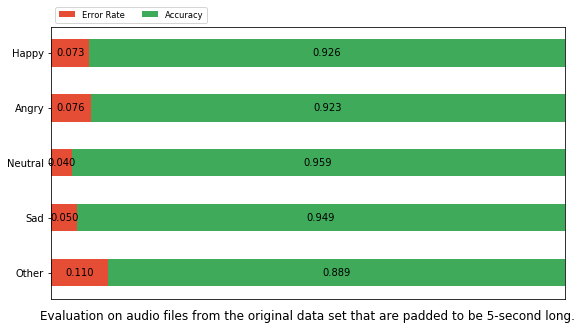

In [24]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on audio files from the original data set that are padded to be 5-second long.'
results = {
    'Happy': [dictionary_original_h.get('error_rate'), dictionary_original_h.get('accuracy')],
    'Angry': [dictionary_original_a.get('error_rate'), dictionary_original_a.get('accuracy')],
    'Neutral': [dictionary_original_n.get('error_rate'), dictionary_original_n.get('accuracy')],
    'Sad': [dictionary_original_s.get('error_rate'), dictionary_original_s.get('accuracy')],
    'Other': [dictionary_original_o.get('error_rate'), dictionary_original_o.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate reverberated wav files

### evaluate the set of Happy validation

In [25]:
dictionary_reverbed_h = eval_reverbed([emotionFolders[0]])
wetdrys_reverbed_h = dictionary_reverbed_h.get('wetdrys')
diffusions_reverbed_h = dictionary_reverbed_h.get('diffusions')
decayfactors_reverbed_h = dictionary_reverbed_h.get('decayfactors')

correct = 277
incorrect = 68
error rate = 0.19710144927536233
accuracy = 0.8028985507246377
total files = 345


### evaluate the set of Angry validation

In [26]:
dictionary_reverbed_a = eval_reverbed([emotionFolders[1]])
wetdrys_reverbed_a = dictionary_reverbed_a.get('wetdrys')
diffusions_reverbed_a = dictionary_reverbed_a.get('diffusions')
decayfactors_reverbed_a = dictionary_reverbed_a.get('decayfactors')

correct = 269
incorrect = 48
error rate = 0.15141955835962145
accuracy = 0.8485804416403786
total files = 317


### evaluate the set of Neutral validation

In [27]:
dictionary_reverbed_n = eval_reverbed([emotionFolders[2]])
wetdrys_reverbed_n = dictionary_reverbed_n.get('wetdrys')
diffusions_reverbed_n = dictionary_reverbed_n.get('diffusions')
decayfactors_reverbed_n = dictionary_reverbed_n.get('decayfactors')

correct = 255
incorrect = 26
error rate = 0.09252669039145907
accuracy = 0.9074733096085409
total files = 281


### evaluate the set of Sad validation

In [28]:
dictionary_reverbed_s = eval_reverbed([emotionFolders[3]])
wetdrys_reverbed_s = dictionary_reverbed_s.get('wetdrys')
diffusions_reverbed_s = dictionary_reverbed_s.get('diffusions')
decayfactors_reverbed_s = dictionary_reverbed_s.get('decayfactors')

correct = 306
incorrect = 20
error rate = 0.06134969325153374
accuracy = 0.9386503067484663
total files = 326


### evaluate the set of Other validation

In [29]:
dictionary_reverbed_o = eval_reverbed([emotionFolders[4]])
wetdrys_reverbed_o = dictionary_reverbed_o.get('wetdrys')
diffusions_reverbed_o = dictionary_reverbed_o.get('diffusions')
decayfactors_reverbed_o = dictionary_reverbed_o.get('decayfactors')

correct = 219
incorrect = 60
error rate = 0.21505376344086022
accuracy = 0.7849462365591398
total files = 279


### draw the plot (evaluation on only the reverberated wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c31ed2080>)

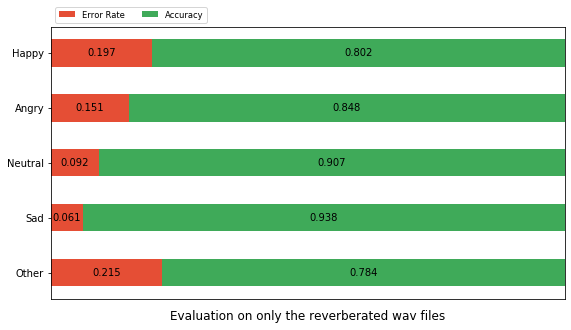

In [30]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the reverberated wav files'
results = {
    'Happy': [dictionary_reverbed_h.get('error_rate'), dictionary_reverbed_h.get('accuracy')],
    'Angry': [dictionary_reverbed_a.get('error_rate'), dictionary_reverbed_a.get('accuracy')],
    'Neutral': [dictionary_reverbed_n.get('error_rate'), dictionary_reverbed_n.get('accuracy')],
    'Sad': [dictionary_reverbed_s.get('error_rate'), dictionary_reverbed_s.get('accuracy')],
    'Other': [dictionary_reverbed_o.get('error_rate'), dictionary_reverbed_o.get('accuracy')]
}

draw(results, category_names, graph_title)

## Only evaluate deamplified and noised wav files

### evaluate the set of Happy validation

In [31]:
dictionary_deamplified_noised_h = eval_deamplified_noised([emotionFolders[0]])

one_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('one_scores')
zero_scores_deamplified_noised_h = dictionary_deamplified_noised_h.get('zero_scores')
deamplified_dbs_deamplified_noised_h = dictionary_deamplified_noised_h.get('deamplified_dbs')
wetdrys_deamplified_noised_h = dictionary_deamplified_noised_h.get('wetdrys')
diffusions_deamplified_noised_h = dictionary_deamplified_noised_h.get('diffusions')
decayfactors_deamplified_noised_h = dictionary_deamplified_noised_h.get('decayfactors')

correct = 549
incorrect = 46
error rate = 0.0773109243697479
accuracy = 0.9226890756302522
total files = 595


### evaluate the set of Angry validation

In [32]:
dictionary_deamplified_noised_a = eval_deamplified_noised([emotionFolders[1]])

one_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('one_scores')
zero_scores_deamplified_noised_a = dictionary_deamplified_noised_a.get('zero_scores')
deamplified_dbs_deamplified_noised_a = dictionary_deamplified_noised_a.get('deamplified_dbs')
wetdrys_deamplified_noised_a = dictionary_deamplified_noised_a.get('wetdrys')
diffusions_deamplified_noised_a = dictionary_deamplified_noised_a.get('diffusions')
decayfactors_deamplified_noised_a = dictionary_deamplified_noised_a.get('decayfactors')

correct = 586
incorrect = 48
error rate = 0.07570977917981073
accuracy = 0.9242902208201893
total files = 634


### evaluate the set of Neutral validation

In [33]:
dictionary_deamplified_noised_n = eval_deamplified_noised([emotionFolders[2]])

one_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('one_scores')
zero_scores_deamplified_noised_n = dictionary_deamplified_noised_n.get('zero_scores')
deamplified_dbs_deamplified_noised_n = dictionary_deamplified_noised_n.get('deamplified_dbs')
wetdrys_deamplified_noised_n = dictionary_deamplified_noised_n.get('wetdrys')
diffusions_deamplified_noised_n = dictionary_deamplified_noised_n.get('diffusions')
decayfactors_deamplified_noised_n = dictionary_deamplified_noised_n.get('decayfactors')

correct = 531
incorrect = 50
error rate = 0.08605851979345955
accuracy = 0.9139414802065404
total files = 581


### evaluate the set of Sad validation

In [34]:
dictionary_deamplified_noised_s = eval_deamplified_noised([emotionFolders[3]])

one_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('one_scores')
zero_scores_deamplified_noised_s = dictionary_deamplified_noised_s.get('zero_scores')
deamplified_dbs_deamplified_noised_s = dictionary_deamplified_noised_s.get('deamplified_dbs')
wetdrys_deamplified_noised_s = dictionary_deamplified_noised_s.get('wetdrys')
diffusions_deamplified_noised_s = dictionary_deamplified_noised_s.get('diffusions')
decayfactors_deamplified_noised_s = dictionary_deamplified_noised_s.get('decayfactors')

correct = 560
incorrect = 72
error rate = 0.11392405063291139
accuracy = 0.8860759493670886
total files = 632


### evaluate the set of Other validation

In [35]:
dictionary_deamplified_noised_o = eval_deamplified_noised([emotionFolders[4]])

one_scores_deamplified_noised_o = dictionary_deamplified_noised_o.get('one_scores')
zero_scores_deamplified_noised_o = dictionary_deamplified_noised_o.get('zero_scores')
deamplified_dbs_deamplified_noised_o = dictionary_deamplified_noised_o.get('deamplified_dbs')
wetdrys_deamplified_noised_o = dictionary_deamplified_noised_o.get('wetdrys')
diffusions_deamplified_noised_o = dictionary_deamplified_noised_o.get('diffusions')
decayfactors_deamplified_noised_o = dictionary_deamplified_noised_o.get('decayfactors')

correct = 543
incorrect = 144
error rate = 0.2096069868995633
accuracy = 0.7903930131004366
total files = 687


### draw the plot (evaluation on only the wav files that are deamplified and mixed with noise)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2b10b400>)

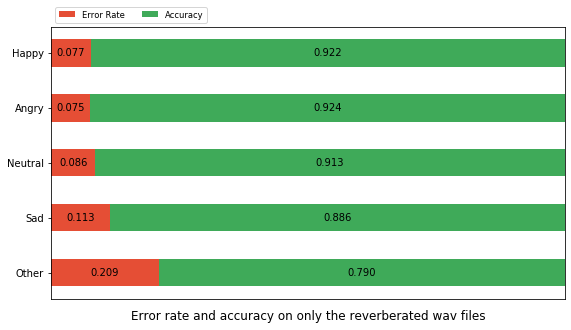

In [36]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Error rate and accuracy on only the reverberated wav files'
results = {
    'Happy': [dictionary_deamplified_noised_h.get('error_rate'), dictionary_deamplified_noised_h.get('accuracy')],
    'Angry': [dictionary_deamplified_noised_a.get('error_rate'), dictionary_deamplified_noised_a.get('accuracy')],
    'Neutral': [dictionary_deamplified_noised_n.get('error_rate'), dictionary_deamplified_noised_n.get('accuracy')],
    'Sad': [dictionary_deamplified_noised_s.get('error_rate'), dictionary_deamplified_noised_s.get('accuracy')],
    'Other': [dictionary_deamplified_noised_o.get('error_rate'), dictionary_deamplified_noised_o.get('accuracy')]
}

draw(results, category_names, graph_title)

In [37]:
h = [deamplified_dbs_deamplified_noised_h, zero_scores_deamplified_noised_h]
a = [deamplified_dbs_deamplified_noised_a, zero_scores_deamplified_noised_a]
n = [deamplified_dbs_deamplified_noised_n, one_scores_deamplified_noised_n]
s = [deamplified_dbs_deamplified_noised_s, one_scores_deamplified_noised_s]
o = [deamplified_dbs_deamplified_noised_o, one_scores_deamplified_noised_o]

title = 'How deamplification affects the performance of the classifier in the presence of background noise'
xlabel = 'Deamplified amount measured in decibels'
ylabel = 'Score on the ground truth class of an audio clip'
#graphs.draw_scatter(h, a, n, s, title, xlabel, ylabel)


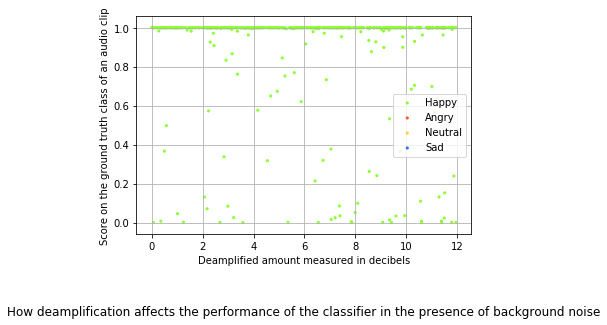

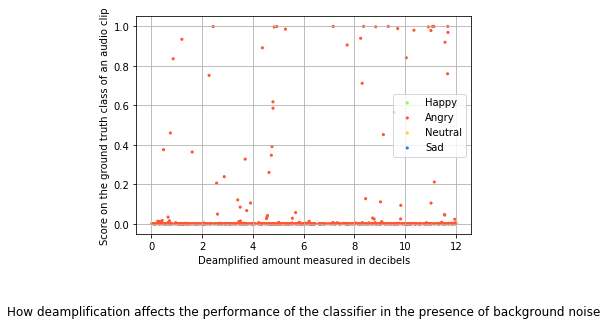

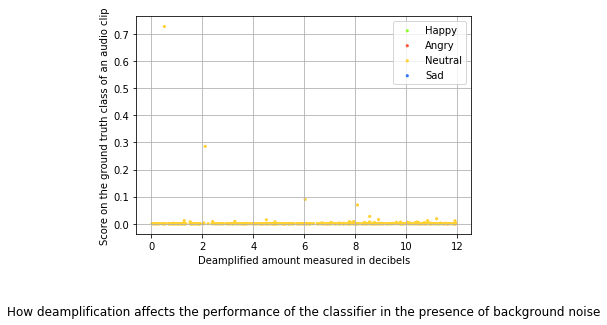

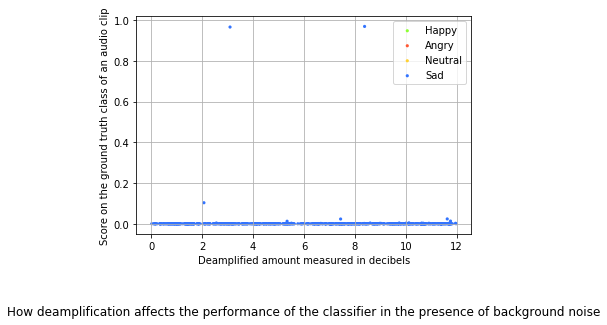

In [38]:
graphs.draw_scatter(h, [[],[]], [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], a, [[],[]], [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], n, [[],[]], title, xlabel, ylabel)
graphs.draw_scatter([[],[]], [[],[]], [[],[]], s, title, xlabel, ylabel)

## Only evaluate deamplified and noised and reverberated wav files

### evaluate the set of Happy validation

In [39]:
dictionary_deamplified_noised_reverbed_h = eval_deamplified_noised_reverbed([emotionFolders[0]])

one_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('one_scores')
zero_scores_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('wetdrys')
diffusions_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('diffusions')
decayfactors_deamplified_noised_reverbed_h = dictionary_deamplified_noised_reverbed_h.get('decayfactors')

deamp_8.219405347510113_noise_home_82_Happy930_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_1.2934488993661284_noise_home_82_Happy1194_WetDry_8_DecayFactor_8_Diffusion_5.npy
deamp_8.470667874988834_noise_home_2_Happy276_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_11.263821208844892_noise_home_27_Happy1121_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_6.8166039588336265_noise_home_83_Happy699_WetDry_4_DecayFactor_8_Diffusion_5.npy
deamp_8.54634907550863_noise_home_81_Happy1438_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_4.335006990832104_noise_home_2_Happy527_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_0.33002768578388775_noise_home_2_Happy1437_WetDry_6_DecayFactor_8_Diffusion_3.npy
deamp_3.7905971221581987_noise_home_23_Happy1495_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_9.22185117441964_noise_home_83_Happy41_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_4.210591904117088_noise_home_80_Happy1787_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_7.113624095114414_noise_home_80_Happy1053_

deamp_8.763217888632674_noise_home_88_Happy340_WetDry_8_DecayFactor_4_Diffusion_3.npy
deamp_7.454837161667086_noise_home_83_Happy1217_WetDry_4_DecayFactor_2_Diffusion_3.npy
deamp_1.3408541582737632_noise_home_81_Happy130_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_8.111277040014382_noise_home_82_Happy1500_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_6.980006454733088_noise_home_83_Happy277_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_1.4833376313286197_noise_home_83_Happy807_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_9.428215013054858_noise_home_25_Happy430_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_11.300042600872267_noise_home_81_Happy607_WetDry_4_DecayFactor_8_Diffusion_4.npy
deamp_1.2488401528271802_noise_home_88_Happy73_WetDry_2_DecayFactor_2_Diffusion_3.npy
deamp_8.699041007919739_noise_home_82_Happy1059_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_10.25214286964508_noise_home_26_Happy1771_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_4.677668056753006_noise_home_81_Happy26_W

deamp_3.5796871088166586_noise_home_27_Happy453_WetDry_2_DecayFactor_8_Diffusion_3.npy
deamp_0.3718078687495763_noise_home_80_Happy1109_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_11.255575226818296_noise_home_22_Happy879_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_6.973746622058799_noise_home_23_Happy1752_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_3.6561596782650034_noise_home_23_Happy474_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_2.739923674670367_noise_home_83_Happy1173_WetDry_6_DecayFactor_6_Diffusion_3.npy
deamp_11.39838733322572_noise_home_80_Happy357_WetDry_2_DecayFactor_6_Diffusion_2.npy
deamp_3.0855697217509066_noise_home_81_Happy1100_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_7.68191932673904_noise_home_2_Happy1769_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_3.6982377745006585_noise_home_24_Happy1595_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_0.5604464464308743_noise_home_23_Happy1374_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_5.164023072201596_noise_home_83_Happ

deamp_10.563233722784842_noise_home_82_Happy1215_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_0.9850955533275991_noise_home_83_Happy339_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_10.787610240217806_noise_home_81_Happy1192_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_6.284695620398588_noise_home_81_Happy271_WetDry_4_DecayFactor_4_Diffusion_2.npy
deamp_3.3689612673566813_noise_home_81_Happy486_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_5.331569188978811_noise_home_82_Happy1294_WetDry_4_DecayFactor_2_Diffusion_6.npy
deamp_0.4131369240906029_noise_home_82_Happy282_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_5.367874462784487_noise_home_26_Happy762_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_3.815347374995231_noise_home_25_Happy851_WetDry_4_DecayFactor_8_Diffusion_4.npy
deamp_2.1912570769192308_noise_home_26_Happy712_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_6.149048833515954_noise_home_26_Happy907_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_1.602217001300183_noise_home_80_Happy77

deamp_1.9762760738177994_noise_home_2_Happy1279_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_8.436472684209644_noise_home_26_Happy1116_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_9.650043809157104_noise_home_83_Happy1177_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_6.70309135652291_noise_home_27_Happy1131_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_4.6845492105764155_noise_home_83_Happy1416_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_0.014192512034123084_noise_home_81_Happy175_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_0.3060064773403104_noise_home_82_Happy927_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_7.459667515796136_noise_home_81_Happy1472_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_0.2122210024624125_noise_home_23_Happy748_WetDry_6_DecayFactor_8_Diffusion_3.npy
deamp_2.469373404723087_noise_home_23_Happy467_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_3.505045504043643_noise_home_24_Happy1298_WetDry_4_DecayFactor_6_Diffusion_4.npy
deamp_10.211224642008846_noise_home_22_Hap

deamp_4.8666019389185315_noise_home_82_Happy141_WetDry_8_DecayFactor_6_Diffusion_2.npy
deamp_4.62691414167476_noise_home_2_Happy829_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_0.17761058017355102_noise_home_22_Happy1487_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_4.717774288621552_noise_home_2_Happy907_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_6.439868663982095_noise_home_88_Happy687_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_3.1615262193378597_noise_home_2_Happy67_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_8.132594373624386_noise_home_24_Happy1553_WetDry_4_DecayFactor_2_Diffusion_3.npy
deamp_2.0272227458638503_noise_home_82_Happy1309_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_5.960305416509019_noise_home_81_Happy441_WetDry_4_DecayFactor_8_Diffusion_2.npy
deamp_6.710527026366561_noise_home_24_Happy779_WetDry_2_DecayFactor_2_Diffusion_4.npy
deamp_9.186643594057735_noise_home_23_Happy324_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_0.25999790369984455_noise_home_83_Happy306_We

deamp_6.234421517577968_noise_home_26_Happy890_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_3.267569029471542_noise_home_83_Happy942_WetDry_4_DecayFactor_2_Diffusion_6.npy
deamp_7.678866239341639_noise_home_23_Happy1712_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_11.440130179644266_noise_home_88_Happy642_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_8.123094321465105_noise_home_82_Happy956_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_10.922477035221384_noise_home_80_Happy850_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_8.661133372616511_noise_home_25_Happy0_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_8.235636797512221_noise_home_26_Happy595_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_9.324538763214903_noise_home_24_Happy850_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_11.528175364300814_noise_home_80_Happy91_WetDry_2_DecayFactor_4_Diffusion_3.npy
deamp_7.658270867908347_noise_home_24_Happy1242_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_6.216434180861134_noise_home_23_Happy150_WetDr

deamp_3.579561391324658_noise_home_25_Happy1172_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_0.931920927536479_noise_home_81_Happy400_WetDry_4_DecayFactor_2_Diffusion_6.npy
deamp_11.760958340099407_noise_home_81_Happy1232_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_5.843061975784704_noise_home_88_Happy603_WetDry_2_DecayFactor_8_Diffusion_5.npy
deamp_6.3187838009511745_noise_home_81_Happy1264_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_7.044788086756821_noise_home_82_Happy706_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_1.9202814131102963_noise_home_83_Happy299_WetDry_6_DecayFactor_8_Diffusion_5.npy
deamp_3.49269557398079_noise_home_25_Happy1556_WetDry_4_DecayFactor_8_Diffusion_4.npy
deamp_3.134520374806059_noise_home_26_Happy41_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_3.8499127575642347_noise_home_88_Happy891_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_5.111706539193962_noise_home_22_Happy543_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_7.674983391667814_noise_home_27_Happy650_W

### evaluate the set of Angry validation

In [40]:
dictionary_deamplified_noised_reverbed_a = eval_deamplified_noised_reverbed([emotionFolders[1]])

one_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('one_scores')
zero_scores_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('wetdrys')
diffusions_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('diffusions')
decayfactors_deamplified_noised_reverbed_a = dictionary_deamplified_noised_reverbed_a.get('decayfactors')

deamp_11.517513973209176_noise_home_23_Angry681_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_3.904454911082019_noise_home_23_Angry1166_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_2.8839094782798997_noise_home_23_Angry1451_WetDry_6_DecayFactor_6_Diffusion_5.npy
deamp_11.238322777532778_noise_home_80_Angry310_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_1.2258728424810785_noise_home_80_Angry1482_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_3.4070364821622023_noise_home_2_Angry315_WetDry_6_DecayFactor_4_Diffusion_6.npy
deamp_1.6378317418909831_noise_home_83_Angry1664_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_2.5192393640577637_noise_home_88_Angry1450_WetDry_4_DecayFactor_8_Diffusion_4.npy
deamp_1.123771421875468_noise_home_80_Angry1469_WetDry_2_DecayFactor_4_Diffusion_3.npy
deamp_1.2102142050880857_noise_home_83_Angry487_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_11.377939133071525_noise_home_82_Angry1409_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_4.661543376288156_noise_home_23_A

deamp_7.443568408468703_noise_home_82_Angry1137_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_7.075909055345358_noise_home_22_Angry117_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_8.508715987573554_noise_home_25_Angry1596_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_4.637751616555326_noise_home_24_Angry547_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_0.8550183458773577_noise_home_23_Angry1325_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_9.028987575956378_noise_home_2_Angry613_WetDry_2_DecayFactor_6_Diffusion_2.npy
deamp_1.8845879265986882_noise_home_83_Angry410_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_6.493762869489814_noise_home_24_Angry675_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_9.571656918789298_noise_home_81_Angry1205_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_0.43486704119680875_noise_home_24_Angry793_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_9.972528397073111_noise_home_22_Angry361_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_7.17358370708455_noise_home_82_Angry398_W

deamp_6.516972106927929_noise_home_88_Angry611_WetDry_8_DecayFactor_2_Diffusion_3.npy
deamp_5.610773609588901_noise_home_23_Angry1496_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_9.674509084137807_noise_home_83_Angry618_WetDry_2_DecayFactor_8_Diffusion_3.npy
deamp_5.4240597937653625_noise_home_24_Angry798_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_1.3530851402861708_noise_home_2_Angry1724_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_3.0924693630801294_noise_home_81_Angry917_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_8.287039750775193_noise_home_23_Angry303_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_1.2062985420395407_noise_home_83_Angry89_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_10.714953012843525_noise_home_82_Angry557_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_7.89244872886135_noise_home_25_Angry21_WetDry_8_DecayFactor_2_Diffusion_3.npy
deamp_8.974061476341838_noise_home_82_Angry1739_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_9.86471197675569_noise_home_2_Angry1633_WetD

deamp_11.494305783205203_noise_home_82_Angry1656_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_5.023931648900692_noise_home_23_Angry989_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_6.39965855270447_noise_home_83_Angry187_WetDry_8_DecayFactor_4_Diffusion_6.npy
deamp_5.857296896272632_noise_home_80_Angry1378_WetDry_6_DecayFactor_8_Diffusion_5.npy
deamp_9.438111115754824_noise_home_25_Angry489_WetDry_2_DecayFactor_8_Diffusion_6.npy
deamp_8.073570819080004_noise_home_23_Angry118_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_7.438857234176519_noise_home_83_Angry1559_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_10.287150728863951_noise_home_81_Angry1395_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_5.8823925215350865_noise_home_82_Angry1316_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_4.31764496758762_noise_home_88_Angry987_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_5.949243245422425_noise_home_81_Angry1772_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_8.155218135614108_noise_home_23_Angry1424

deamp_3.9264446893043496_noise_home_81_Angry530_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_5.143294433143939_noise_home_81_Angry1235_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_3.2305964460340624_noise_home_2_Angry812_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_8.902340698769523_noise_home_24_Angry350_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_0.6668568853290564_noise_home_23_Angry1501_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_7.709727585629361_noise_home_82_Angry1298_WetDry_2_DecayFactor_4_Diffusion_5.npy
deamp_1.1394119960674018_noise_home_83_Angry847_WetDry_8_DecayFactor_6_Diffusion_6.npy
deamp_2.1933037317025152_noise_home_80_Angry691_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_7.452223921149427_noise_home_80_Angry850_WetDry_8_DecayFactor_4_Diffusion_5.npy
deamp_3.6364720737349794_noise_home_24_Angry429_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_1.603918175709207_noise_home_80_Angry463_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_10.322530211150935_noise_home_80_Angry12

deamp_7.026707961059498_noise_home_80_Angry225_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_1.4998003836383238_noise_home_81_Angry610_WetDry_8_DecayFactor_4_Diffusion_3.npy
deamp_9.754624733468294_noise_home_80_Angry1743_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_10.844012854924827_noise_home_26_Angry48_WetDry_8_DecayFactor_6_Diffusion_2.npy
deamp_2.763749441247884_noise_home_80_Angry1767_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_10.543867093135923_noise_home_23_Angry44_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_0.7837968573135945_noise_home_25_Angry1238_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_7.289784686848064_noise_home_83_Angry564_WetDry_4_DecayFactor_8_Diffusion_4.npy
deamp_1.848547331299975_noise_home_25_Angry1788_WetDry_4_DecayFactor_6_Diffusion_4.npy
deamp_9.94139402457079_noise_home_24_Angry651_WetDry_4_DecayFactor_6_Diffusion_6.npy
deamp_5.5825918058517185_noise_home_80_Angry838_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_8.77539396522784_noise_home_26_Angry323_We

deamp_5.065333093948938_noise_home_82_Angry121_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_0.5328332147335169_noise_home_2_Angry662_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_2.9427574611040166_noise_home_83_Angry19_WetDry_8_DecayFactor_4_Diffusion_5.npy
deamp_6.838390111652519_noise_home_80_Angry81_WetDry_2_DecayFactor_2_Diffusion_4.npy
deamp_4.5207058569158995_noise_home_23_Angry1620_WetDry_6_DecayFactor_2_Diffusion_5.npy
deamp_7.978613930817817_noise_home_82_Angry1168_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_2.3489498425147732_noise_home_82_Angry532_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_9.6345596125554_noise_home_26_Angry890_WetDry_6_DecayFactor_4_Diffusion_6.npy
deamp_0.8508943679078369_noise_home_27_Angry1545_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_7.410633244952997_noise_home_80_Angry153_WetDry_4_DecayFactor_8_Diffusion_5.npy
deamp_3.931155727540852_noise_home_80_Angry1443_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_8.030180366758671_noise_home_27_Angry1516_We

### evaluate the set of Neutral validation

In [41]:
dictionary_deamplified_noised_reverbed_n = eval_deamplified_noised_reverbed([emotionFolders[2]])

one_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('one_scores')
zero_scores_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('wetdrys')
diffusions_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('diffusions')
decayfactors_deamplified_noised_reverbed_n = dictionary_deamplified_noised_reverbed_n.get('decayfactors')

deamp_5.4832499065805385_noise_home_81_Neutral493_WetDry_2_DecayFactor_4_Diffusion_5.npy
deamp_0.7786665639220978_noise_home_81_Neutral1198_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_2.5223943899025287_noise_home_81_Neutral145_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_8.884192574432541_noise_home_23_Neutral90_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_3.4044890714322773_noise_home_88_Neutral955_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_7.625197802607697_noise_home_23_Neutral963_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_4.582961423239476_noise_home_83_Neutral1072_WetDry_6_DecayFactor_8_Diffusion_3.npy
deamp_0.41187504417337806_noise_home_2_Neutral1131_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_9.58687815514979_noise_home_27_Neutral1492_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_11.583459350228367_noise_home_2_Neutral7_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_10.215830891044252_noise_home_80_Neutral754_WetDry_4_DecayFactor_8_Diffusion_6.npy
deamp_4.5651464033458335_n

deamp_1.74899802169098_noise_home_83_Neutral1144_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_0.27026956904649646_noise_home_23_Neutral944_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_3.949760804416134_noise_home_23_Neutral136_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_2.999769026800299_noise_home_25_Neutral181_WetDry_8_DecayFactor_8_Diffusion_3.npy
deamp_8.90433501769062_noise_home_25_Neutral183_WetDry_2_DecayFactor_8_Diffusion_5.npy
deamp_5.036902217942989_noise_home_24_Neutral337_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_10.85260872031171_noise_home_25_Neutral444_WetDry_8_DecayFactor_6_Diffusion_6.npy
deamp_2.4975355708452587_noise_home_24_Neutral517_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_11.507272464348302_noise_home_2_Neutral977_WetDry_8_DecayFactor_4_Diffusion_5.npy
deamp_5.632563049963599_noise_home_25_Neutral1467_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_5.9921302602081425_noise_home_82_Neutral102_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_2.403205641511693_nois

deamp_10.835187482151175_noise_home_81_Neutral317_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_4.401283932268926_noise_home_23_Neutral8_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_6.522938174579705_noise_home_23_Neutral1209_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_5.570628002060893_noise_home_88_Neutral300_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_8.94149520946418_noise_home_25_Neutral990_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_2.236651040557879_noise_home_82_Neutral459_WetDry_6_DecayFactor_2_Diffusion_3.npy
deamp_8.04104986521251_noise_home_88_Neutral707_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_3.2044629720057207_noise_home_2_Neutral406_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_6.877943822036835_noise_home_88_Neutral1468_WetDry_8_DecayFactor_6_Diffusion_4.npy
deamp_7.548284631509796_noise_home_24_Neutral215_WetDry_4_DecayFactor_8_Diffusion_3.npy
deamp_5.677768303738587_noise_home_80_Neutral246_WetDry_8_DecayFactor_8_Diffusion_5.npy
deamp_9.691164028476779_noise_hom

deamp_2.3024643867998646_noise_home_81_Neutral1383_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_1.9025827161806865_noise_home_22_Neutral1126_WetDry_8_DecayFactor_4_Diffusion_4.npy
deamp_3.0128059818216193_noise_home_88_Neutral26_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_3.4709241060436034_noise_home_23_Neutral1398_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_4.1648304511605545_noise_home_81_Neutral514_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_10.823130336917405_noise_home_24_Neutral224_WetDry_6_DecayFactor_6_Diffusion_3.npy
deamp_9.059087066353943_noise_home_82_Neutral49_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_6.799137703245451_noise_home_23_Neutral661_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_5.26623482807772_noise_home_23_Neutral1414_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_9.961606238235401_noise_home_23_Neutral772_WetDry_2_DecayFactor_8_Diffusion_5.npy
deamp_7.33724563559622_noise_home_80_Neutral62_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_0.02938750506544041_n

deamp_4.5024869035564015_noise_home_88_Neutral571_WetDry_8_DecayFactor_8_Diffusion_3.npy
deamp_11.063114117987734_noise_home_82_Neutral868_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_4.838290573557666_noise_home_23_Neutral944_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_4.443430440029742_noise_home_23_Neutral170_WetDry_6_DecayFactor_4_Diffusion_2.npy
deamp_4.849860999451936_noise_home_83_Neutral1357_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_6.4641567760130725_noise_home_23_Neutral1190_WetDry_6_DecayFactor_6_Diffusion_6.npy
deamp_9.433070499151887_noise_home_25_Neutral879_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_2.842680590123055_noise_home_80_Neutral706_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_1.3575527139914203_noise_home_88_Neutral1184_WetDry_2_DecayFactor_4_Diffusion_6.npy
deamp_4.972016857101728_noise_home_81_Neutral194_WetDry_2_DecayFactor_2_Diffusion_2.npy
deamp_3.957856676417732_noise_home_23_Neutral1431_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_9.821130553888457_

deamp_5.2907909383011305_noise_home_83_Neutral1345_WetDry_4_DecayFactor_4_Diffusion_3.npy
deamp_5.804841393323763_noise_home_81_Neutral23_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_8.393300078845098_noise_home_81_Neutral1107_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_11.747762539174422_noise_home_82_Neutral103_WetDry_8_DecayFactor_6_Diffusion_6.npy
deamp_5.057837927436424_noise_home_26_Neutral904_WetDry_6_DecayFactor_8_Diffusion_3.npy
deamp_10.527032780734036_noise_home_82_Neutral512_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_10.071885389946043_noise_home_88_Neutral1562_WetDry_6_DecayFactor_4_Diffusion_3.npy
deamp_0.13375610197111332_noise_home_83_Neutral1186_WetDry_2_DecayFactor_8_Diffusion_5.npy
deamp_4.816084909981715_noise_home_26_Neutral340_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_4.830227769308845_noise_home_27_Neutral343_WetDry_2_DecayFactor_4_Diffusion_6.npy
deamp_1.286517564293348_noise_home_25_Neutral161_WetDry_6_DecayFactor_4_Diffusion_6.npy
deamp_0.700355960619551

### evaluate the set of Sad validation

In [42]:
dictionary_deamplified_noised_reverbed_s = eval_deamplified_noised_reverbed([emotionFolders[3]])

one_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('one_scores')
zero_scores_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('wetdrys')
diffusions_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('diffusions')
decayfactors_deamplified_noised_reverbed_s = dictionary_deamplified_noised_reverbed_s.get('decayfactors')

deamp_10.558837732807568_noise_home_83_Sad271_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_10.162272890969474_noise_home_81_Sad432_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_2.6473093181920455_noise_home_24_Sad559_WetDry_4_DecayFactor_6_Diffusion_2.npy
deamp_1.5385406976722433_noise_home_83_Sad227_WetDry_6_DecayFactor_8_Diffusion_6.npy
deamp_4.205454067823293_noise_home_88_Sad654_WetDry_2_DecayFactor_6_Diffusion_2.npy
deamp_7.741928893197821_noise_home_23_Sad1115_WetDry_4_DecayFactor_4_Diffusion_4.npy
deamp_11.073135049885291_noise_home_2_Sad1521_WetDry_2_DecayFactor_6_Diffusion_5.npy
deamp_4.662509652476033_noise_home_81_Sad510_WetDry_6_DecayFactor_6_Diffusion_6.npy
deamp_1.3951464191691314_noise_home_81_Sad162_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_6.059676729423272_noise_home_22_Sad212_WetDry_2_DecayFactor_4_Diffusion_6.npy
deamp_1.9060141658289451_noise_home_81_Sad675_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_3.6651005255369893_noise_home_24_Sad662_WetDry_8_DecayFactor_6

deamp_10.107180456249129_noise_home_26_Sad1294_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_7.055120385429271_noise_home_81_Sad881_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_6.663695293223629_noise_home_22_Sad1766_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_4.987417388385712_noise_home_83_Sad1662_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_2.879744760086129_noise_home_80_Sad591_WetDry_6_DecayFactor_2_Diffusion_5.npy
deamp_7.032938684217017_noise_home_26_Sad1447_WetDry_8_DecayFactor_8_Diffusion_3.npy
deamp_8.686716349213484_noise_home_82_Sad534_WetDry_8_DecayFactor_8_Diffusion_2.npy
deamp_9.754133270435617_noise_home_25_Sad11_WetDry_4_DecayFactor_2_Diffusion_6.npy
deamp_8.053747566941976_noise_home_81_Sad68_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_2.7593683588922433_noise_home_81_Sad1525_WetDry_8_DecayFactor_6_Diffusion_3.npy
deamp_8.796424162774958_noise_home_24_Sad1577_WetDry_6_DecayFactor_8_Diffusion_4.npy
deamp_11.369302013929493_noise_home_80_Sad1290_WetDry_4_DecayFactor_4_

deamp_3.050080146909012_noise_home_81_Sad949_WetDry_8_DecayFactor_4_Diffusion_6.npy
deamp_2.1944335552633594_noise_home_27_Sad316_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_4.473856351992257_noise_home_22_Sad171_WetDry_2_DecayFactor_4_Diffusion_5.npy
deamp_2.314927796900997_noise_home_81_Sad1434_WetDry_2_DecayFactor_6_Diffusion_4.npy
deamp_7.967009767577758_noise_home_82_Sad712_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_7.9920456020630235_noise_home_2_Sad1627_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_1.7775391336742818_noise_home_25_Sad1165_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_0.2506336423623057_noise_home_23_Sad1121_WetDry_2_DecayFactor_2_Diffusion_3.npy
deamp_0.18750656552887124_noise_home_88_Sad77_WetDry_4_DecayFactor_2_Diffusion_5.npy
deamp_8.377172574054192_noise_home_80_Sad1033_WetDry_8_DecayFactor_2_Diffusion_3.npy
deamp_2.860035316067895_noise_home_80_Sad562_WetDry_8_DecayFactor_6_Diffusion_2.npy
deamp_0.886327628904402_noise_home_80_Sad931_WetDry_4_DecayFactor_6

deamp_1.568383745731139_noise_home_26_Sad1686_WetDry_4_DecayFactor_4_Diffusion_5.npy
deamp_2.776489107299734_noise_home_25_Sad1548_WetDry_8_DecayFactor_2_Diffusion_6.npy
deamp_4.258828526816165_noise_home_82_Sad1424_WetDry_8_DecayFactor_8_Diffusion_6.npy
deamp_11.63965949276896_noise_home_81_Sad1670_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_2.9251307554362147_noise_home_81_Sad1700_WetDry_8_DecayFactor_2_Diffusion_4.npy
deamp_2.1759217464574037_noise_home_25_Sad412_WetDry_6_DecayFactor_6_Diffusion_2.npy
deamp_1.0121680318547241_noise_home_83_Sad797_WetDry_6_DecayFactor_2_Diffusion_6.npy
deamp_9.668267879954943_noise_home_82_Sad1635_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_4.887648772860823_noise_home_80_Sad825_WetDry_2_DecayFactor_6_Diffusion_6.npy
deamp_6.50344559829999_noise_home_26_Sad1262_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_8.401002960593756_noise_home_26_Sad1184_WetDry_8_DecayFactor_4_Diffusion_6.npy
deamp_11.417673319824749_noise_home_81_Sad848_WetDry_8_DecayFactor

deamp_0.9295570957151007_noise_home_23_Sad1780_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_6.233511471500387_noise_home_24_Sad465_WetDry_2_DecayFactor_2_Diffusion_6.npy
deamp_2.9527071563777962_noise_home_80_Sad1219_WetDry_4_DecayFactor_2_Diffusion_4.npy
deamp_5.022665723599917_noise_home_27_Sad1113_WetDry_6_DecayFactor_6_Diffusion_4.npy
deamp_2.361082374619303_noise_home_83_Sad574_WetDry_4_DecayFactor_2_Diffusion_3.npy
deamp_9.53761973591759_noise_home_88_Sad1706_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_0.34652282275433155_noise_home_26_Sad1485_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_10.996052884257828_noise_home_22_Sad331_WetDry_6_DecayFactor_6_Diffusion_6.npy
deamp_11.909470618000046_noise_home_25_Sad1137_WetDry_4_DecayFactor_6_Diffusion_6.npy
deamp_4.041931137119416_noise_home_26_Sad63_WetDry_2_DecayFactor_4_Diffusion_2.npy
deamp_3.706813616780552_noise_home_24_Sad556_WetDry_8_DecayFactor_4_Diffusion_2.npy
deamp_0.836832777679549_noise_home_23_Sad1580_WetDry_2_DecayFactor

deamp_3.4572176509964154_noise_home_2_Sad1643_WetDry_8_DecayFactor_6_Diffusion_4.npy
deamp_7.440041279268882_noise_home_82_Sad393_WetDry_4_DecayFactor_2_Diffusion_2.npy
deamp_6.927850441788259_noise_home_2_Sad226_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_11.669908281226485_noise_home_81_Sad1375_WetDry_8_DecayFactor_6_Diffusion_5.npy
deamp_7.088260409248601_noise_home_25_Sad218_WetDry_8_DecayFactor_8_Diffusion_4.npy
deamp_7.52744821823576_noise_home_82_Sad1759_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_7.264336910730526_noise_home_26_Sad890_WetDry_4_DecayFactor_6_Diffusion_3.npy
deamp_4.801016469868205_noise_home_24_Sad1207_WetDry_2_DecayFactor_4_Diffusion_4.npy
deamp_3.9112766062380593_noise_home_25_Sad1521_WetDry_2_DecayFactor_2_Diffusion_5.npy
deamp_7.278107490607767_noise_home_26_Sad80_WetDry_6_DecayFactor_2_Diffusion_2.npy
deamp_4.475206835127562_noise_home_82_Sad1572_WetDry_4_DecayFactor_4_Diffusion_6.npy
deamp_4.769215452326674_noise_home_82_Sad1000_WetDry_2_DecayFactor_6_Di

deamp_3.209162945036819_noise_home_24_Sad40_WetDry_6_DecayFactor_4_Diffusion_4.npy
deamp_1.8561644182341483_noise_home_27_Sad42_WetDry_2_DecayFactor_8_Diffusion_2.npy
deamp_8.222435511555204_noise_home_27_Sad646_WetDry_6_DecayFactor_8_Diffusion_2.npy
deamp_9.786222399226668_noise_home_80_Sad312_WetDry_2_DecayFactor_8_Diffusion_4.npy
deamp_2.1567926411440936_noise_home_24_Sad266_WetDry_4_DecayFactor_6_Diffusion_5.npy
deamp_6.799565241564625_noise_home_82_Sad777_WetDry_6_DecayFactor_4_Diffusion_6.npy
deamp_5.591548945801261_noise_home_22_Sad1571_WetDry_8_DecayFactor_4_Diffusion_6.npy
deamp_8.72282497562784_noise_home_81_Sad1613_WetDry_8_DecayFactor_2_Diffusion_5.npy
deamp_11.269954350885982_noise_home_82_Sad632_WetDry_6_DecayFactor_4_Diffusion_5.npy
deamp_0.8894076028079732_noise_home_81_Sad1536_WetDry_8_DecayFactor_2_Diffusion_2.npy
deamp_0.35446997963552995_noise_home_23_Sad1767_WetDry_8_DecayFactor_4_Diffusion_5.npy
deamp_9.758144235903728_noise_home_80_Sad1692_WetDry_8_DecayFactor_6_

### evaluate the set of Other validation

In [70]:
dictionary_deamplified_noised_reverbed_o = eval_deamplified_noised_reverbed([emotionFolders[4]])

one_scores_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('one_scores')
zero_scores_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('zero_scores')
deamplified_dbs_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('deamplified_dbs')
wetdrys_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('wetdrys')
diffusions_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('diffusions')
decayfactors_deamplified_noised_reverbed_o = dictionary_deamplified_noised_reverbed_o.get('decayfactors')

correct = 0
incorrect = 0


ZeroDivisionError: division by zero

### draw the plot (evaluation on only the wav files that are deamplified, mixed with noise, and reverberated)

In [71]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on only the wav files that are deamplified, mixed with noise, and reverberated'
results = {
    'Happy': [dictionary_deamplified_noised_reverbed_h.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_h.get('accuracy')], \
    'Angry': [dictionary_deamplified_noised_reverbed_a.get('error_rate'), \
              dictionary_deamplified_noised_reverbed_a.get('accuracy')], \
    'Neutral': [dictionary_deamplified_noised_reverbed_n.get('error_rate'), \
                dictionary_deamplified_noised_reverbed_n.get('accuracy')], \
    'Sad': [dictionary_deamplified_noised_reverbed_s.get('error_rate'), \
            dictionary_deamplified_noised_reverbed_s.get('accuracy')],
    'Other': [dictionary_deamplified_noised_reverbed_o.get('error_rate'), \
            dictionary_deamplified_noised_reverbed_o.get('accuracy')]
}

draw(results, category_names, graph_title)

NameError: name 'dictionary_deamplified_noised_reverbed_o' is not defined

## Evaluate all wav files

### evaluate the set of Happy validation

In [43]:
dictionary_all_h = eval_all([emotionFolders[0]])

one_scores_all_h = dictionary_all_h.get('one_scores')
zero_scores_all_h = dictionary_all_h.get('zero_scores')
deamplified_dbs_all_h = dictionary_all_h.get('deamplified_dbs')
wetdrys_all_h = dictionary_all_h.get('wetdrys')
diffusions_all_h = dictionary_all_h.get('diffusions')
decayfactors_all_h = dictionary_all_h.get('decayfactors')

correct = 1762
incorrect = 204
error rate = 0.10376398779247202
accuracy = 0.896236012207528
total files = 1966


### evaluate the set of Angry validation

In [44]:
dictionary_all_a = eval_all([emotionFolders[1]])

one_scores_all_a = dictionary_all_a.get('one_scores')
zero_scores_all_a = dictionary_all_a.get('zero_scores')
deamplified_dbs_all_a = dictionary_all_a.get('deamplified_dbs')
wetdrys_all_a = dictionary_all_a.get('wetdrys')
diffusions_all_a = dictionary_all_a.get('diffusions')
decayfactors_all_a = dictionary_all_a.get('decayfactors')

correct = 1728
incorrect = 214
error rate = 0.1101956745623069
accuracy = 0.8898043254376931
total files = 1942


### evaluate the set of Neutral validation

In [45]:
dictionary_all_n = eval_all([emotionFolders[2]])

one_scores_all_n = dictionary_all_n.get('one_scores')
zero_scores_all_n = dictionary_all_n.get('zero_scores')
deamplified_dbs_all_n = dictionary_all_n.get('deamplified_dbs')
wetdrys_all_n = dictionary_all_n.get('wetdrys')
diffusions_all_n = dictionary_all_n.get('diffusions')
decayfactors_all_n = dictionary_all_n.get('decayfactors')

correct = 1505
incorrect = 191
error rate = 0.11261792452830188
accuracy = 0.8873820754716981
total files = 1696


### evaluate the set of Sad validation

In [46]:
dictionary_all_s = eval_all([emotionFolders[3]])

one_scores_all_s = dictionary_all_s.get('one_scores')
zero_scores_all_s = dictionary_all_s.get('zero_scores')
deamplified_dbs_all_s = dictionary_all_s.get('deamplified_dbs')
wetdrys_all_s = dictionary_all_s.get('wetdrys')
diffusions_all_s = dictionary_all_s.get('diffusions')
decayfactors_all_s = dictionary_all_s.get('decayfactors')

correct = 1735
incorrect = 212
error rate = 0.10888546481766821
accuracy = 0.8911145351823317
total files = 1947


### evaluate the set of Other validation

In [47]:
dictionary_all_o = eval_all([emotionFolders[4]])

one_scores_all_o = dictionary_all_o.get('one_scores')
zero_scores_all_o = dictionary_all_o.get('zero_scores')
deamplified_dbs_all_o = dictionary_all_o.get('deamplified_dbs')
wetdrys_all_o = dictionary_all_o.get('wetdrys')
diffusions_all_o = dictionary_all_o.get('diffusions')
decayfactors_all_o = dictionary_all_o.get('decayfactors')

correct = 1052
incorrect = 240
error rate = 0.18575851393188855
accuracy = 0.8142414860681114
total files = 1292


### draw the plot (evaluation on all the wav files)

(<Figure size 662.4x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2b3d1a90>)

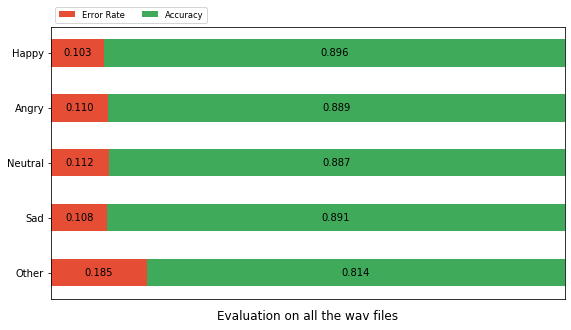

In [48]:
category_names = ['Error Rate', 'Accuracy']
graph_title = 'Evaluation on all the wav files'
results = {
    'Happy': [dictionary_all_h.get('error_rate'), dictionary_all_h.get('accuracy')],
    'Angry': [dictionary_all_a.get('error_rate'), dictionary_all_a.get('accuracy')],
    'Neutral': [dictionary_all_n.get('error_rate'), dictionary_all_n.get('accuracy')],
    'Sad': [dictionary_all_s.get('error_rate'), dictionary_all_s.get('accuracy')],
    'Other': [dictionary_all_o.get('error_rate'), dictionary_all_o.get('accuracy')]
}

draw(results, category_names, graph_title)

In [78]:
predict_cnn(model)

Accuracy: 0.9411998410806516
Precision: 0.8802030456852792
Recall: 0.8928939237899073
f1 score: 0.8865030674846625
